H vs (E and S)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


No optimiser

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5667 - loss: 414.4079 - val_accuracy: 0.6111 - val_loss: 59.8609
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 635ms/step - accuracy: 0.7061 - loss: 37.5680 - val_accuracy: 0.5000 - val_loss: 13.4170
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 815ms/step - accuracy: 0.6301 - loss: 31.3726 - val_accuracy: 0.6111 - val_loss: 5.8149
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 669ms/step - accuracy: 0.7315 - loss: 2.9795 - val_accuracy: 0.6111 - val_loss: 2.7543
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 953ms/step - accuracy: 0.8417 - loss: 0.7742 - val_accuracy: 0.8778 - val_loss: 0.3068
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 857ms/step - accuracy: 0.8159 - loss: 1.1586 - val_accuracy: 0.6667 - val_loss: 0.7526
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9146 - loss: 0.3356 - val_accuracy: 0.7333 - val_loss: 0.6035
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 733ms/step - accuracy: 0.9706 - loss: 0.0817 - val_accuracy: 0.7889 - val_los

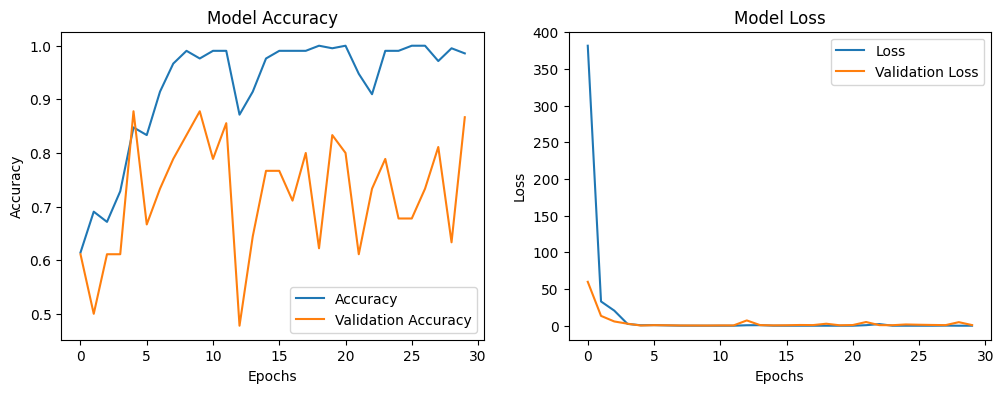

In [ ]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (label 0)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (label 1)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (label 1)

# Combine data and labels for Healthy vs (Seizure + Epileptic)
if data_Healthy.size > 0 and (data_Seizure.size > 0 or data_Epileptic.size > 0):
    data_all = np.concatenate((data_Healthy, data_Seizure, data_Epileptic), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Seizure, labels_Epileptic), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Healthy, 1 for Seizure/Epileptic)
    ])

    # Compile the model without specifying an optimizer (using default behavior)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


with standarisation

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 738ms/step - accuracy: 0.6311 - loss: 2.1121 - val_accuracy: 0.6222 - val_loss: 0.5054
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 636ms/step - accuracy: 0.7170 - loss: 0.4299 - val_accuracy: 0.7444 - val_loss: 0.4960
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 809ms/step - accuracy: 0.8309 - loss: 0.3731 - val_accuracy: 0.7667 - val_loss: 0.4688
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 667ms/step - accuracy: 0.8729 - loss: 0.3409 - val_accuracy: 0.5778 - val_loss: 0.8044
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 848ms/step - accuracy: 0.6539 - loss: 0.8623 - val_accuracy: 0.6333 - val_loss: 0.5066
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 655ms/step - accuracy: 0.8031 - loss: 0.3190 - val_accuracy: 0.7222 - val_loss: 0.5035
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 951ms/step - accuracy: 0.8366 - loss: 0.3067 - val_accuracy: 0.7667 - val_loss: 0.4308
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 797ms/step - accuracy: 0.9082 - loss: 0.2771 - val_accuracy: 0.7444 - val_loss:

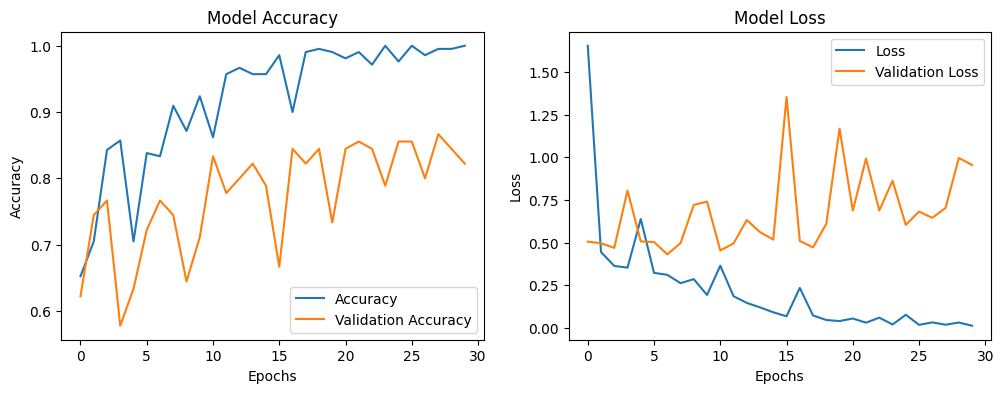

In [3]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for data standardization

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (label 0)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (label 1)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (label 1)

# Combine data and labels for Healthy vs (Seizure + Epileptic)
if data_Healthy.size > 0 and (data_Seizure.size > 0 or data_Epileptic.size > 0):
    data_all = np.concatenate((data_Healthy, data_Seizure, data_Epileptic), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Seizure, labels_Epileptic), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Healthy, 1 for Seizure/Epileptic)
    ])

    # Compile the model without specifying an optimizer (using default behavior)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


with Optimiser

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6018 - loss: 116.3289 - val_accuracy: 0.6111 - val_loss: 96.7608
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 675ms/step - accuracy: 0.6789 - loss: 94.7629 - val_accuracy: 0.6111 - val_loss: 32.8747
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 971ms/step - accuracy: 0.7008 - loss: 15.8864 - val_accuracy: 0.7667 - val_loss: 1.7540
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 744ms/step - accuracy: 0.7609 - loss: 1.7326 - val_accuracy: 0.7444 - val_loss: 0.8339
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 848ms/step - accuracy: 0.7909 - loss: 0.9113 - val_accuracy: 0.6111 - val_loss: 1.5671
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 882ms/step - accuracy: 0.7064 - loss: 0.9412 - val_accuracy: 0.6111 - val_loss: 0.7265
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 814ms/step - accuracy: 0.8402 - loss: 0.3491 - val_accuracy: 0.8222 - val_loss: 0.4242
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 686ms/step - accuracy: 0.9037 - loss: 0.2731 - val_accuracy: 0.8222 - val

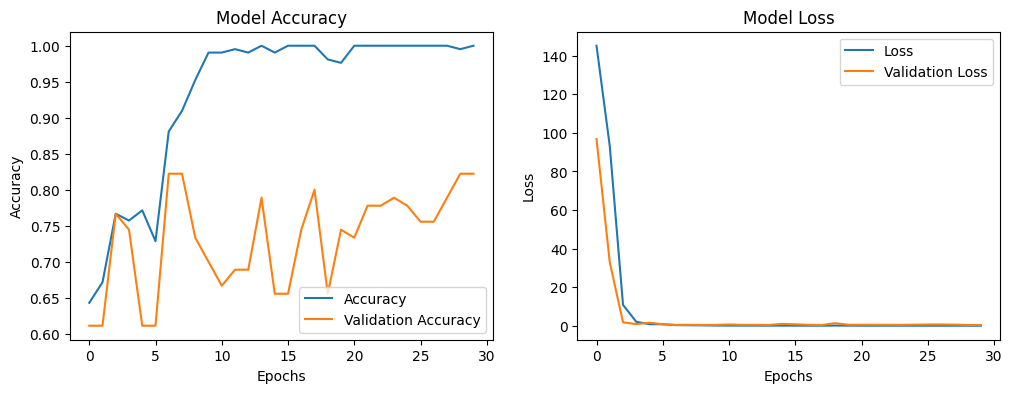

In [ ]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (label 0)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (label 1)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (label 1)

# Combine data and labels for Healthy vs (Seizure + Epileptic)
if data_Healthy.size > 0 and (data_Seizure.size > 0 or data_Epileptic.size > 0):
    data_all = np.concatenate((data_Healthy, data_Seizure, data_Epileptic), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Seizure, labels_Epileptic), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Healthy, 1 for Seizure/Epileptic)
    ])

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


with both optoimiser and standarisation

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 724ms/step - accuracy: 0.5983 - loss: 1.5952 - val_accuracy: 0.6222 - val_loss: 0.5117
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 738ms/step - accuracy: 0.7263 - loss: 0.5012 - val_accuracy: 0.6333 - val_loss: 0.5244
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 669ms/step - accuracy: 0.8144 - loss: 0.3906 - val_accuracy: 0.7556 - val_loss: 0.4819
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 932ms/step - accuracy: 0.8603 - loss: 0.3981 - val_accuracy: 0.7000 - val_loss: 0.5246
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 664ms/step - accuracy: 0.8890 - loss: 0.3120 - val_accuracy: 0.7889 - val_loss: 0.4602
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 935ms/step - accuracy: 0.8521 - loss: 0.3115 - val_accuracy: 0.7667 - val_loss: 0.4976
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 696ms/step - accuracy: 0.8968 - loss: 0.2610 - val_accuracy: 0.7778 - val_loss: 0.5015
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 969ms/step - accuracy: 0.8971 - loss: 0.2512 - val_accuracy: 0.8000 - val_loss

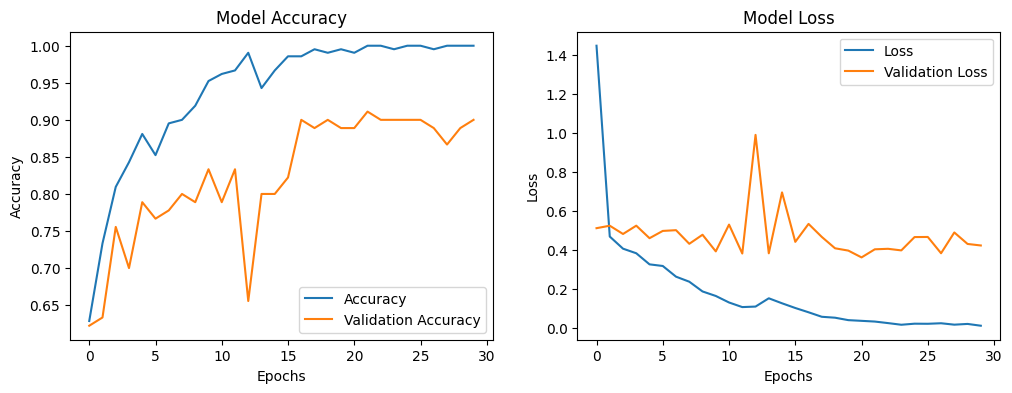

In [4]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for data standardization

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (label 0)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (label 1)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (label 1)

# Combine data and labels for Healthy vs (Seizure + Epileptic)
if data_Healthy.size > 0 and (data_Seizure.size > 0 or data_Epileptic.size > 0):
    data_all = np.concatenate((data_Healthy, data_Seizure, data_Epileptic), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Seizure, labels_Epileptic), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Healthy, 1 for Seizure/Epileptic)
    ])

    # Compile the model with Adam optimizer
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")
